In [4]:
import os.path as path
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [5]:
from pycromanager import Core, Studio

In [6]:
from smartpath_libraries.sp_stitcher import SPStitcher
from smartpath_libraries.sp_acquisition import SPAcquisition

In [3]:
## config : default config only:  changed will be saved to expt folder
import yaml
##  import SPdeeplearning #LSM Enhancer
from IPython.utils import io as ipio
## read image: background correction
from skimage import io as skio
# pos list
import pickle

In [7]:
working_directory = os.getcwd()

In [8]:
def init_pycromanager():
    from pycromanager import Core, Studio
    core = Core()
    studio = Studio()
    core.set_timeout_ms(20000)
    return core, studio
core,studio = init_pycromanager()

In [9]:
assert os.getcwd() == working_directory

In [10]:
def init_qupath():
    qupath_folder = os.path.join('QuPath-0.4.3','QuPath-0.4.3.exe')
    if os.path.exists(qupath_folder):
        return qupath_folder
    else:
        raise OSError(2, 'Qupath exe not found at', qupath_folder)
        
qupath_fname = init_qupath()
print(qupath_fname)

QuPath-0.4.3\QuPath-0.4.3.exe


In [11]:
assert os.getcwd() == working_directory

In [12]:
## Config Loading
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config['user_config'], **config['model_config'], **config['hard_config']}
lsm_pixel_size_base = config['pixel-size-shg-base']
bf_4x_pixel_size_base = config['pixel-size-bf-4x']
bf_20x_pixel_size_base = config['pixel-size-bf-20x']
camera_resolution_base = config['camera-resolution']

## config browse

In [34]:
def obj_to_list(name):
    name = [name.get(i) for i in range(name.size())]
    return name

In [36]:
obj_to_list(core.get_loaded_devices())

['COM3',
 'OScHub',
 'OSc-LSM',
 'OSc-Magnifier',
 'DCCHub',
 'DCCModule1',
 'NIMultiAnalogDev1',
 'LED-Dev1ao0',
 'PockelsCell-Dev1ao1',
 'Shutters-DigitalIODev1',
 'UniblitzShutter',
 'QCamera',
 'TigerCommHub',
 'XYStage:XY:31',
 'ZStage:Z:32',
 'ZStage:F:32',
 'Turret:O:35',
 'WhiteLED',
 'Core']

In [43]:
for device_name in obj_to_list(core.get_loaded_devices()): 
    device_prop = core.get_device_property_names(device_name) 
    print(device_name,"::",obj_to_list(device_prop)) 
    props = obj_to_list(device_prop) 
    for prop in props: 
        val = core.get_property(device_name, prop) 
        print(prop,":", val) 
    print("-----")
        

COM3 :: ['AnswerTimeout', 'BaudRate', 'DTR', 'DataBits', 'DelayBetweenCharsMs', 'Description', 'Fast USB to Serial', 'Handshaking', 'Name', 'Parity', 'StopBits', 'Verbose']
AnswerTimeout : 500.0000
BaudRate : 115200
DTR : Disable
DataBits : 8
DelayBetweenCharsMs : 0.0000
Description : Serial port driver (boost:asio)
Fast USB to Serial : Disable
Handshaking : Off
Name : COM3
Parity : None
StopBits : 1
Verbose : 1
-----
OScHub :: []
-----
OSc-LSM :: ['Binning', 'Clock', 'Detector', 'Exposure', 'LSM-PixelRateHz', 'LSM-Resolution', 'LSM-ZoomFactor', 'PXI1Slot2-Acq Buffer Size (lines)', 'PXI1Slot2-EnableChannel0', 'PXI1Slot2-EnableChannel1', 'PXI1Slot2-EnableChannel2', 'PXI1Slot2-EnableChannel3', 'PXI1Slot2-EnableChannel4', 'PXI1Slot2-EnableChannel5', 'PXI1Slot2-EnableChannel6', 'PXI1Slot2-EnableChannel7', 'PXI1Slot2-GalvoOffsetX (degree)', 'PXI1Slot2-GalvoOffsetY (degree)', 'PXI1Slot2-Input Voltage Range', 'PXI1Slot2-Line Delay (pixels)', 'PXI1Slot2-Parking Position X (pixels)', 'PXI1Slot2

In [53]:
for device_name in [ #'XYStage:XY:31',
                     #'ZStage:Z:32',
                     #'ZStage:F:32',
                     'Turret:O:35',]: 
    device_prop = core.get_device_property_names(device_name) 
    #print(device_name,"::",obj_to_list(device_prop)) 
    props = obj_to_list(device_prop) 
    for prop in props: 
        val = core.get_property(device_name, prop) 
        print(prop,":", val) 
    print("-----")
        

AxisLetter : O
Description : ASI Turret Axis=O HexAddr=35
FirmwareBuild : OBJ_SLIDER_SLDR8
FirmwareDate : Aug 30 2019:16:15:21
FirmwareVersion : 3.3000
JoystickInput : 0 - none
Label : Position-1
Name : Turret:O:35
NumPositions : 2
RefreshPropertyValues : No
SaveCardSettings : no action
State : 0
TigerHexAddress : 35
-----


In [44]:
obj_to_list(core.get_available_config_groups())

['ColorON',
 'Imaging',
 'LSM-Camera Switch',
 'PMT Gain',
 'PMT HV ON',
 'PixelRate',
 'Pixels',
 'PockelCell',
 'System',
 'WhiteLEDBrightness',
 'Zoom']

In [46]:
obj_to_list(core.get_available_configs('Imaging'))

['Camera', 'LSM']

In [47]:
auto_shutter = core.get_property('Core', 'AutoShutter')
##core.set_property('Core', 'AutoShutter', 0)
auto_shutter

'1'

In [62]:
## show status
xy_stage_position= core.get_xy_stage_position()
print(f"Z={core.get_position():.1f} XY={xy_stage_position.x:.1f}, {xy_stage_position.y:.1f} || {core.get_position('ZStage:Z:32'):.1f} , {core.get_position('ZStage:F:32'):.1f} || {core.get_property('Turret:O:35', 'Label')}")

def get_status(core):
    return f"Z={core.get_position():.1f} XY={xy_stage_position.x:.1f}, {xy_stage_position.y:.1f} || {core.get_position('ZStage:Z:32'):.1f} , {core.get_position('ZStage:F:32'):.1f} || {core.get_property('Turret:O:35', 'Label')}"

Z=-6917.9 XY=5879.1, 9996.5 || -6917.9 , -18500.0 || Position-1


In [ ]:
#core.get_available_devices()
#core.get_device_adapter_names()
#core.get_device_property_names()
#core.get_available_property_blocks()

In [ ]:
get_status(core)

In [63]:
## User configuration block
save_path = 'data/acquisition' # do not change
acq_name = 'fail_test2' # current session name No Spaces in name! Use - or _ No `ome` in name!
slide_box = [5000, 9000, 9000, 14000] # [bottom left corner, and top right corner]
brightfield_4x_background_fname = 'data/presets/BG_4x.tiff' # give a default 4x background image
brightfield_20x_background_fname = 'data/presets/BG_20x.tiff' # give a default 20x background image

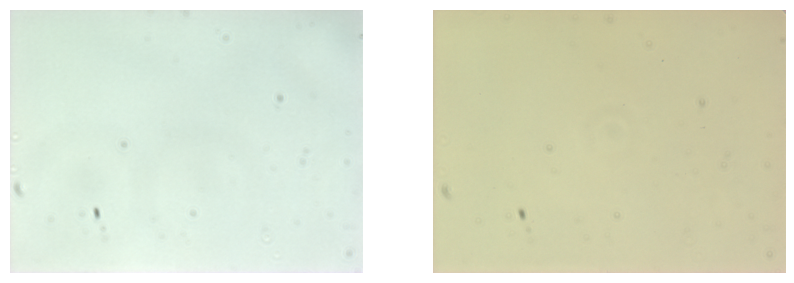

In [66]:
bf_4x_bg=skio.imread(brightfield_4x_background_fname)
bf_20x_bg=skio.imread(brightfield_20x_background_fname)
_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(bf_4x_bg, label='4x background'), ax[1].imshow(bf_20x_bg), ax[0].axis('off'), ax[1].axis('off');

In [ ]:
sp_acq = SPAcquisition(
    config=config,
    mmcore=core, 
    mmstudio=studio,
    bf_4x_bg=skio.imread(brightfield_4x_background_fname), 
    bf_20x_bg=skio.imread(brightfield_20x_background_fname), 
    )

In [ ]:
qupath_fname = os.path.join('QuPath-0.4.3', 'QuPath-0.4.3.exe') # QuPath executable, os.sep does matter!!!
sp_sti = SPStitcher(
    config=config, 
    ij=ij,
    working_dir=save_path,
    qupath_dir=qupath_fname, 
    )

In [ ]:
sp_acq.update_slide_box(slide_box)
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x

## 4X acqusition

In [24]:
acq_name_4x = acq_name + '-4x-bf' 
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')

In [ ]:
### Focus on the sample
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [ ]:
sp_acq.update_focus_presets(mag='4x', mod='bf') # update focus preset
sp_acq.config['autofocus-speed'] = 4 # default is 4 ## `1-6`, the larger the faster, but potentially worse autofocusing resuls.

**Troubleshooting**:
1. First several images are not in focused. --> Stop the acquisition, focus on the sample again and re-run the cell that update the focus presets.  
2. Some images in the middle are not in focused. --> Stop the acquisition, reduce the autofocusing speed.  
3. Images in focused, but color looks off. --> Acquire a new background image, and set the path to `brightfield_4x_background_fname` variable, re-run from that cell.
4. Error out with java types messages. --> Close (or stop) any live view running in Micro-Manager. 
5. Memory related error messages. --> Increase maximum available memory size for Java run-time.
6. If you get an array size error by indexing into an empty list, your slide_box size is too small (To be fixed). Less than an entire tile causes this error.

In [27]:
### perform the scan

#sp_acq.switch_objective(mag='4x')
#sp_acq.switch_mod(mod='bf')
core.set_shutter_open(True)
core.set_auto_shutter(False)
core.set_shutter_open(True)
#position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
#sp_acq.position_list_4x = position_list_4x
#print(position_list_4x)

In [28]:
## saves tiff files into 
# "C:\Users\lociuser\Codes\smart-wsi-scanner\data\acquisition\carolina_test_1-4x-bf_10"
results_4x = sp_acq.whole_slide_bf_scan(
    save_path, 
    acq_name_4x, 
    position_list_4x.reshape(position_list_4x.shape[0]*position_list_4x.shape[1], -1), 
    mag='4x',
    focus_dive=True,
    estimate_background=False,
    )
### save background image and z positions, and position_list

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:17<00:00,  2.16s/it]


In [29]:
results_4x['Position list'] = position_list_4x
sp_acq.z_list_4x = results_4x['Z positions']
with open(path.join(save_path, acq_name_4x+'.pkl'), 'wb') as f:
    pickle.dump(results_4x, f)

In [30]:
### perform the stitching
position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
with ipio.capture_output() as captured:
    sp_sti.stitch_bf(
        acq_name_4x,
        mag='4x',
        position_list=position_list,
        flip_y=True,
        correction=False, # this should be set `True` if the default background image was not given during the acquisition
        background_image=None # this should be given as `loaded_results_4x['Background image']` `correction` is `True`
        )
    print(captured)

In [ ]:
sp_sti.convert_slide(mag='4x')
### optional clean the intermediate stitching files
sp_sti.clean_folders(acq_name_4x)

- Draw annotations using QuPath
You can find the instructions [here](https://docs.google.com/document/d/1bNAhTBUaounlFZqjYNVf6zONRItLhQPYPVLXFLlFEpU/edit?usp=sharing).  
Before proceeding, make sure position lists are successfully saved in `qupath-projects/mp-tiles/` and `qupath-projects/20x-tiles/`. The file names should start with something like `[acq_name]-4x-bf-[ROI_name]`.

## 20X acqusition

In [ ]:
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')

In [ ]:
## Interupt the process to stop live
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [ ]:
sp_acq.update_focus_presets(mag='20x', mod='bf')
sp_acq.config["autofocus-speed"] = 4 

In [37]:
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')
core.set_shutter_open(True)
core.set_auto_shutter(False)
core.set_shutter_open(True)
with open(path.join(save_path, acq_name_4x+'.pkl'), 'rb') as f:
    loaded_results_4x = pickle.load(f)
sp_acq.position_list_4x = loaded_results_4x['Position list']
sp_acq.z_list_4x = loaded_results_4x['Z positions']
position_list_xyz = np.concatenate((   
    sp_acq.position_list_4x, 
    sp_acq.z_list_4x.reshape((sp_acq.position_list_4x.shape[0], sp_acq.position_list_4x.shape[1], 1))
    ), 2)
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
### perform the scan
sp_acq.position_list_20x = []
sp_acq.z_list_20x = []
for idx, (roi_pos, roi_name) in tqdm(enumerate(zip(position_lists_20x, annotation_names))):
    current_acq_name = acq_name + '-20x-' + annotation_names[idx]
    sampled_pos_xyz = sp_acq.resample_z_pos(mag='20x', xy_pos=roi_pos, xyz_pos_list_4x=position_list_xyz)
    results_20x = sp_acq.whole_slide_bf_scan(
        save_path, 
        current_acq_name, 
        sampled_pos_xyz, 
        mag='20x',
        focus_dive=True,
        estimate_background=False,
        )
    sp_acq.position_list_20x.append(sampled_pos_xyz)
    sp_acq.z_list_20x.append(results_20x['Z positions'])
    sp_acq.config['Z-stage-20x'] = np.mean(np.vstack(sp_acq.z_list_20x))
    ### save background image and z positions, and position_list
    position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
    with ipio.capture_output() as captured:
        sp_sti.stitch_bf(
            current_acq_name,
            mag='20x',
            position_list=sampled_pos_xyz,
            flip_y=True,
            correction=False, 
            background_image=None 
            )
    sp_sti.convert_slide(mag='20x')
    #TODO: failing when multiple ROI
    try:
        sp_sti.clean_folders(current_acq_name) # optional
    except Exception as e:
        print('Failed to delete temporary stitching files')
        print(e)
np.save(os.path.join(save_path, acq_name +'-20x'+'-z_pos.npy'), sp_acq.z_list_20x, allow_pickle=True)
#sp_acq.switch_objective(mag='4x')
#sp_acq.switch_mod(mod='bf')


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


## 20X SHG

### Change SHG scan settings
Available values:
```
"lsm-scan-rate" : '50000.0000', '100000.0000', '125000.0000', '200000.0000'. This is a string '.0000' is necessary.
"lsm-pc-power" : 0-0.7, default is 0.5
"lsm-pmt-gain" : 0-0.8, default is 0.7
"lsm-resolution" : 256, 512, 1024, default is 512 or 256
```

In [38]:
sp_acq.config["lsm-scan-rate"] = '200000.0000' # slow: '100000.0000'; fast: '500000.0000'
sp_acq.config["lsm-pc-power"] = 0.6 # max 0.8
sp_acq.config["lsm-pmt-gain"] = 0.6 # max 0.8 
sp_acq.config["lsm-resolution"] = 256 # slow: 512; fast: 256
sample_depth = 20 # um 3*thickness
z_step = 5 # number of steps
lsm_name = '-lsm-median-256-' # append to file name
#sp_acq.core.set_property('OSc-LSM', 'PXI2Slot2-GalvoOffsetX (degree)', 0.0) # (optional) 
# Adjustment to match FOV of different settings, use 0.45 for fast setting, use 0.0 for slow setting

In [39]:
sp_acq.config_preset(sp_acq.config)
sp_sti.config = sp_acq.config
sp_acq.dump_configuration(acq_name)
sp_acq.switch_objective(mag='20x')
sp_acq.switch_mod(mod='shg')

### Runtime processer

In [29]:
## ignore to remove pre-processing functions in MDA-Pycromanager

In [57]:
### Median filter for example
from skimage.filters import median
from skimage.morphology import diamond, disk, square
func = lambda image: median(image, footprint=square(2))
# func = lambda image: image # just pass the image witout processing
sp_acq.define_lsm_processor(func)

In [95]:
### A wavelet denoiser
# from skimage.restoration import denoise_wavelet
# def func(image):
#     denoised = denoise_wavelet(image, rescale_sigma=True)
#     return denoised
# sp_acq.define_lsm_processor(func)

In [96]:
### A total varition-based denoiser
# from skimage.restoration import denoise_tv_chambolle
# def func(image):
#     denoised = denoise_tv_chambolle(image, weight=0.005)
#     return denoised
# sp_acq.define_lsm_processor(func)

In [97]:
### Deep neural networks (2x upscale)
# from smartpath_libraries.enhancer import Enhancer
# import torch
# model_config = config
# enhancer = Enhancer(model_config, scale_factor=model_config['up-scale-factor'], perceptual_loss=True, adversarial_loss=True)
# enhancer.backbone.load_state_dict(torch.load(os.path.join('weights', 'enhancer.pth')))
# sp_acq.lsm_enhancer = enhancer
# sp_acq.define_lsm_processor(network=True)
# # The pixel size for SHG will change if the images are upscaled.
# sp_sti.config["pixel-size-shg"] = lsm_pixel_size_base / 2

In [41]:
skip_roi_id = 0 # `skip_roi_id` varible to `N` will skip the first N ROIs 

In [ ]:
- Individual ROIs are saved at `data/slides/mp`.  
**Trouble shooting**  
1. Repeatly says "PMT overloaded!" --> The PMT is off or your signal is too bright. Reduce PMT gain.  
2. It won't stop. --> Click the stop button multiple times, 
    or click restart button (also on the top menu bar of the notebook). 
    If the kernel is restarted, you will have to run from the beginning and resume the session by running some necessary cells.
3. No signal. --> The current FOV does not contain detectable structures, 
    or the PMT is off, or the laser shutter is off, or the laser modelock is off. 
    Check the hardware setup section of this 
    [guide](https://docs.google.com/document/d/1mAJuh3Eu8Bkt_IAWVCzh7XT79KacVCjf/edit?usp=sharing&ouid=111512958445591507194&rtpof=true&sd=true). 

In [42]:
## part 1
sp_acq.switch_objective(mag='20x')
sp_acq.switch_mod(mod='shg')
core.set_shutter_open(True)
core.set_auto_shutter(False)
core.set_shutter_open(True)

## part 2
position_lists_mp, annotation_mp = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='mp')
position_lists_mp, annotation_mp = zip(*sorted(zip(position_lists_mp, annotation_mp), key=lambda x: int(x[1].split('-')[-1])))
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
return_20x_list = np.load(os.path.join(save_path, acq_name+'-20x'+'-z_pos.npy'), allow_pickle=True).tolist()
return_20x_list = np.vstack(return_20x_list)
map_xyz_20x = np.concatenate((np.vstack(position_lists_20x), return_20x_list.reshape((return_20x_list.shape[0], 1))), 1)
sp_acq.lsm_reset_PMT()

## test parameter types
## msot errors associated with pos-list : list of lists , tuples of 3D, etc

## Part 3
for idx, (roi_pos, roi_name) in enumerate(zip(position_lists_mp, 
                                              annotation_mp)):
    if idx < skip_roi_id: continue
    current_acq_name = acq_name + lsm_name + roi_name
    # roi_pos[:, 0] = roi_pos[:, 0] #- 2907
    # roi_pos[:, 1] = roi_pos[:, 1] #+ 3183 
    sampled_pos_xyz_mp = sp_acq.resample_z_pos(mag='mp', xy_pos=roi_pos, xyz_pos_list_20x=map_xyz_20x)
    sp_acq.whole_slide_lsm_scan(
        save_path, 
        acq_name=current_acq_name, 
        position_list=sampled_pos_xyz_mp, 
        z_stack=True, 
        sample_depth=sample_depth, 
        z_step=z_step
        )
    num_channel = int(sample_depth/z_step)+1
    with ipio.capture_output() as captured:
        sp_sti.stitch_lsm(
            save_path, 
            current_acq_name, 
            n_stack=5, # just keep it as 3, the actual number of stacks can be different 
            position_list=sampled_pos_xyz_mp, 
            flip_y=False, 
            rotate=270
            )
        sp_sti.convert_slide(mag='mp')
    try:
        sp_sti.clean_folders(current_acq_name) # optional
    except Exception as e:
        print('Failed to delete temporary stitching files')
        print(e)


 Take away your data in `data/acquisition` folder! 
--Mike "I think this should be slides?"
 You can also find a copy of your configuration file in `acquisition-configs` folder.
 

In [6]:
user_config = {
    
    ### User configuration ###
    
    # Quick configuration group for LSM
    "exposure-level" : 'high',
    # 'low'     -> scan rate: '500000.0000', pockel cell gain: 0.30, PMT gain: 0.40
    # 'mid'     -> scan rate: '400000.0000', pockel cell gain: 0.45, PMT gain: 0.45
    # 'high'    -> scan rate: '250000.0000', pockel cell gain: 0.60, PMT gain: 0.50
    # 'extreme' -> scan rate: '200000.0000', pockel cell gain: 0.75, PMT gain: 0.55
    
    "snr-level" : 'low',
    # Estimiated correction according to sample SNR level. Available value: 'low', 'mid', 'high', by default raw data is collected
    
    "autofocus-speed" : 3,
    # Speed of software autofocus, integer: 1~5. Bigger value leads to faster brightfield scan but potentially lower autofocus performance
       
    "lsm-resolution" : 256, 
    # LSM scan resolution, available resolution: 256, 512, 1024
    
    "lsm-bin-factor" : 15,
    # LSM scan pixel average factor, positive integer
    
    "lsm-scan-rate" : '250000.0000', 
    # LSM scan rate, available value (string): '125000.0000', '200000.0000', '250000.0000','400000.0000', '500000.0000', '625000.0000', '1000000.0000'
    
    "lsm-pc-power" : 0.4, 
    # LSM pockel cell gain, float point value: 0.0 ~ 1.0
    
    "lsm-pmt-gain" : 0.4,
    # LSM PMT gain, float point value: 0.0 ~ 1.0
    
    "slide-box" : (-100, 600, 25500.0, 17000.0), 
    # Pre-define scan area (read out values from the stage): (start x stage position, start y stage position, end x stage position, end y stage position)
    
    "lsm-enhancer" : None,
    
    "bf-enhancer" : None,
    
    "classifier" : None,
    # Automatic target detection model, available value (string or None): 'MIL', 'Supervised', None 
    
}

model_config = {
    
    "gpu" : False,
    # Is GPU available? Available value (boolean): True, False
    
    "batch-size" : 32,
    # Is GPU available? Available value (boolean): True, False 
    
    ### configure enhancer ###
    
    "image-channel" : 1,
    
    "dropout-rate" : 0.1, 
    
    "cnn-base-channel" : 4,
    
    "normalization" : None,
    # CNN normalization layere type
    
    "norm-range" : (13251, 63085),
    # Image normalization range, determined via *_dataset_preprocessing.ipynb in lsm-run-time-enhancement repo
         
    
    "dimension" : '2D',
    
    ### configure classifier
    
    "classifier-backbone" : 'ResNet18',
    # Backbone for CNN model, available value (string): 'ResNet18', 'ResNet34' 
    
    "classifier-num-class" : 2,
    # Number of class for the detector, non-zero integer
    
    "mil-classifier-thresh" : 2,
    # Threshold for MIL classifier. Obtained from training.
    
    "slide-type" : 'TMA',
    # Type of image the inference is applied, available value (string): "TMA", "slide"      

}

### right general save range check function
hard_config = {
    ### Hard configuration, 
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
#     "Z-stage-20x" : -6930, # -6930 + 290 / 10500
    "Z-stage-20x" : -6980, # -6930 + 290 / 10500
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15800, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "Z-bf-offset" : -10500,
    "Z-laser-offset" : 290,
    "hard-limit-z" : (-8500.0, 17000.0),
    "hard-limit-x" : (-5000.0, 40000.0),
    "hard-limit-y" : (-4200, 25000.0), #(-2200, 19000.0)
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}